# **Data preparation for training**

Investigate dataset and prepare the dataset for binary classification.

# **Import the required libraries**

In [ ]:
import pandas
import numpy
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, make_scorer, f1_score, recall_score, average_precision_score
import seaborn
import matplotlib.pyplot as plt
import itertools

# Just for clearing the outputs, removing Python warnings.
import warnings
warnings.filterwarnings("ignore")

# **Load the raw dataset**

Mount Google Drive and load the dataset into a Pandas Dataframe.

In [ ]:
# Diabetes dataset from Kaggle
# https://www.kaggle.com/datasets/mathchi/diabetes-data-set

original_data: pandas.DataFrame = pandas.read_csv("diabetes.csv")

Mounted at /content/drive


In [ ]:
original_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
print("Null values count:")
print(original_data.isnull().sum())

Null values count:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [ ]:
print("Is there any duplications:")
print(original_data.duplicated().any())

Is there any duplications:
False


# **Investigate the target variable**

Target label samples count:
Outcome
0    500
1    268
Name: count, dtype: int64
Target label No Diabates percentage:: 65.1%
Target label Diabetes percentage: 34.9%


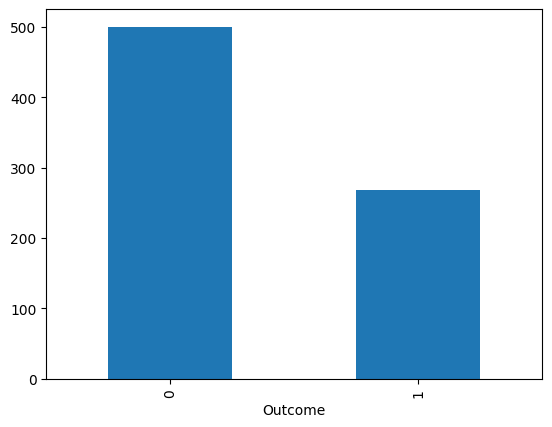

In [ ]:
outcome_values: pandas.Series = original_data["Outcome"].value_counts()
outcome_values.plot(kind="bar")

print("Target label samples count:")
print(original_data["Outcome"].value_counts())

print(f"Target label No Diabates percentage:: {round(outcome_values[0] / original_data['Outcome'].count() * 100, 2)}%")
print(f"Target label Diabetes percentage: {round(outcome_values[1] / original_data['Outcome'].count() * 100, 2)}%")

# **Investigate independendent variables (features)**

In [ ]:
def diagnostic_plots(df, variable, target, save):
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 4, 1)
    seaborn.histplot(df[variable], kde = True, color='r')
    plt.title('Histogram')

    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable], df[target], color = 'g')
    plt.title('Scatterplot')

    # boxplot
    plt.subplot(1, 4, 3)
    seaborn.boxplot(y=df[variable], color = 'b')
    plt.title('Boxplot')

    # barplot
    plt.subplot(1, 4, 4)
    seaborn.barplot(x = target, y = variable, data = df)
    plt.title('Barplot')

    if save:
      plt.savefig(variable + ".pdf")
    plt.show()

In [ ]:
original_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


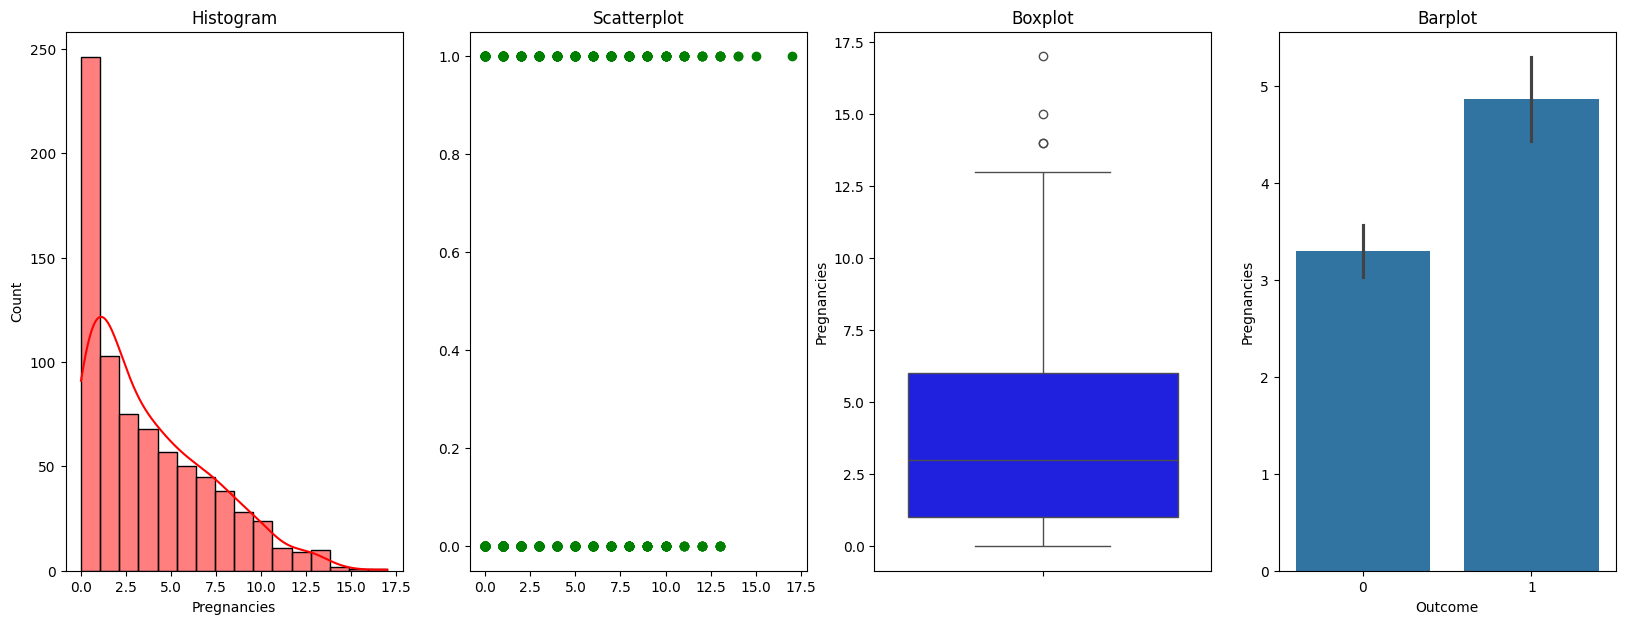

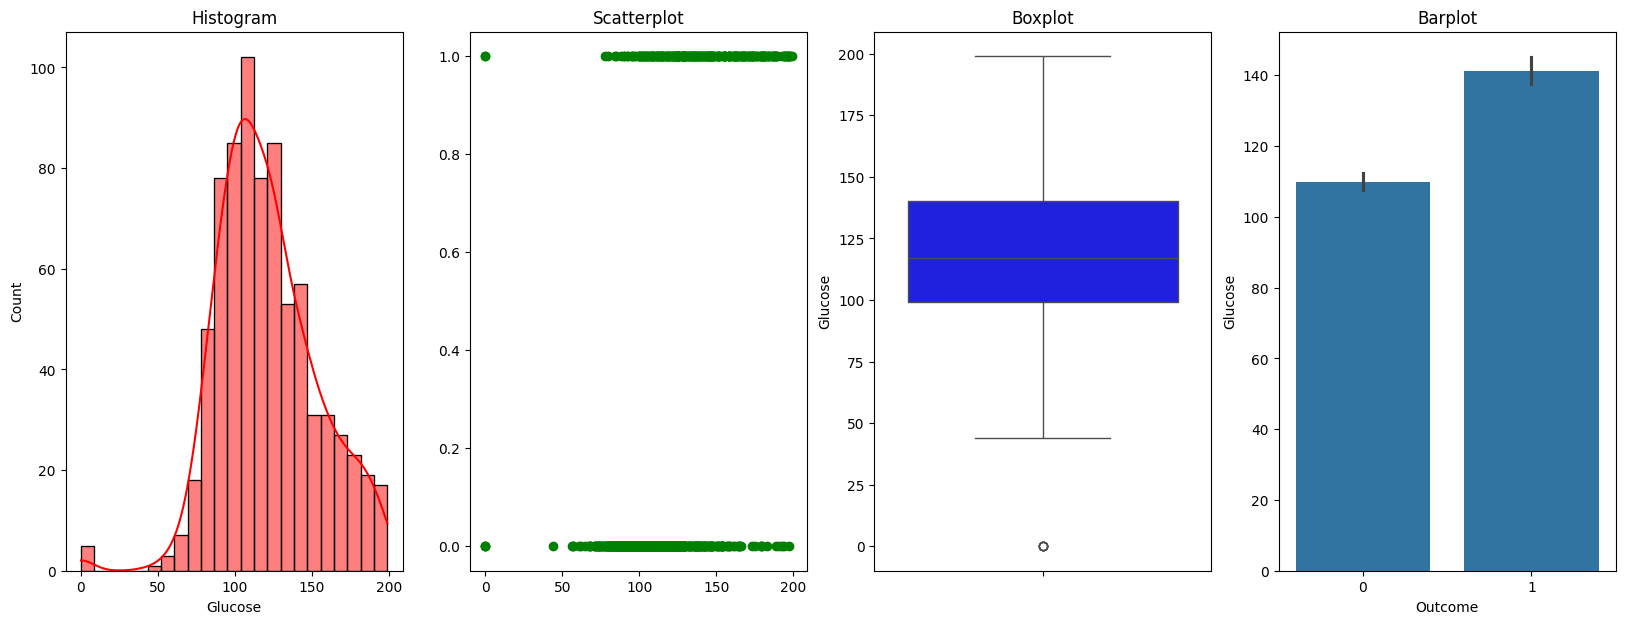

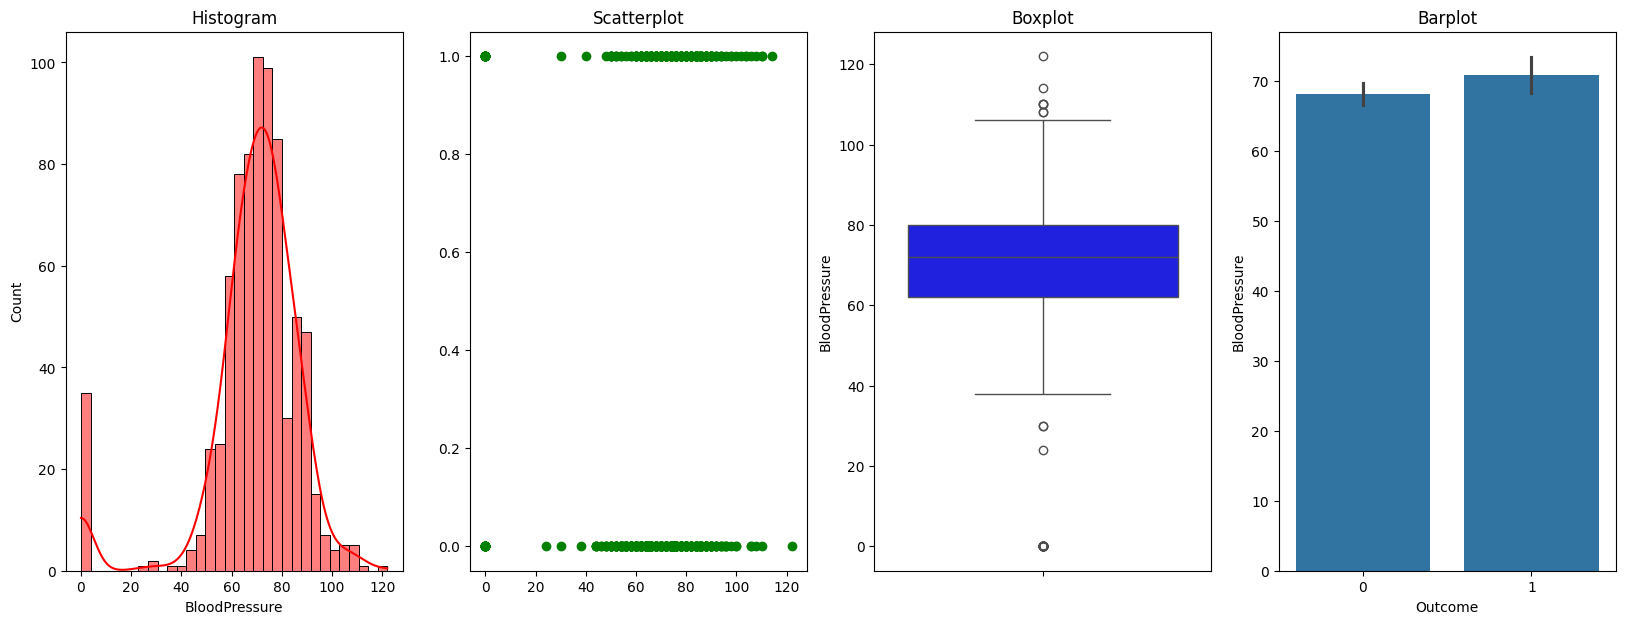

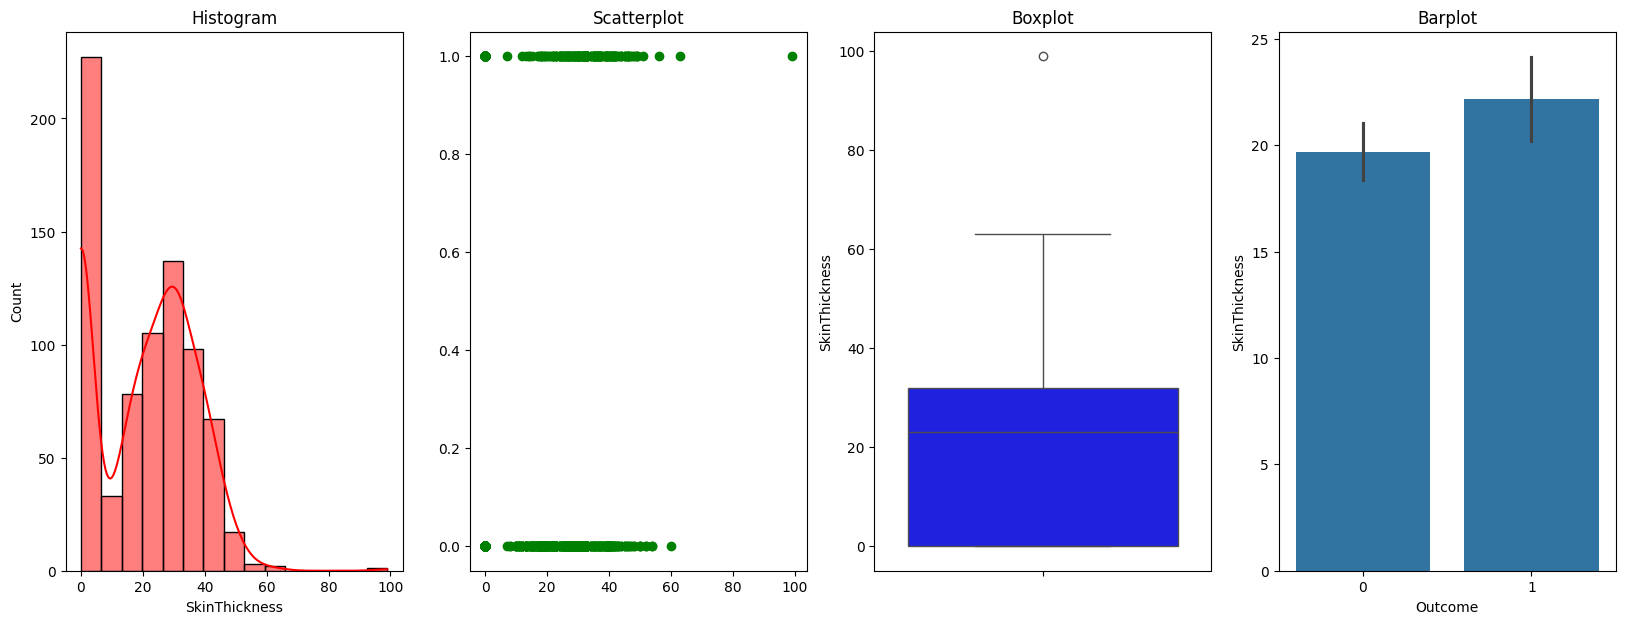

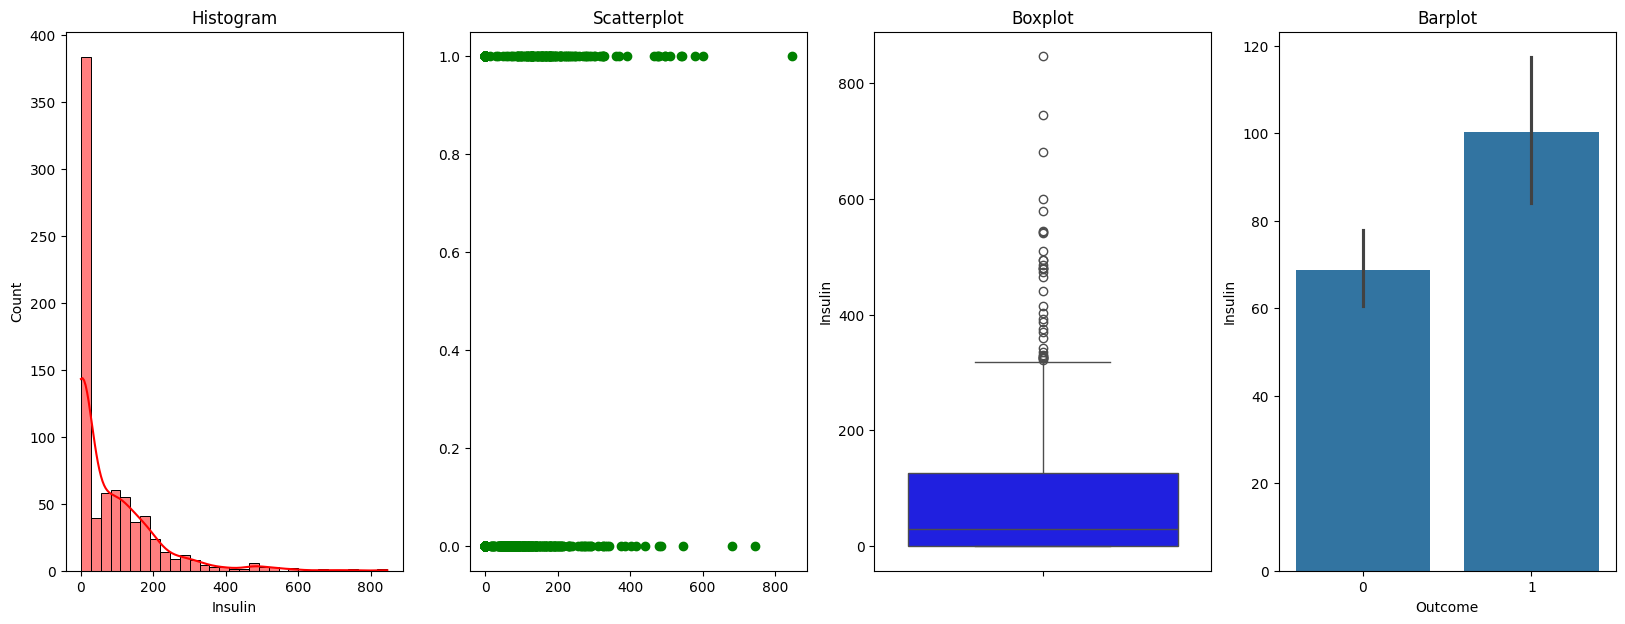

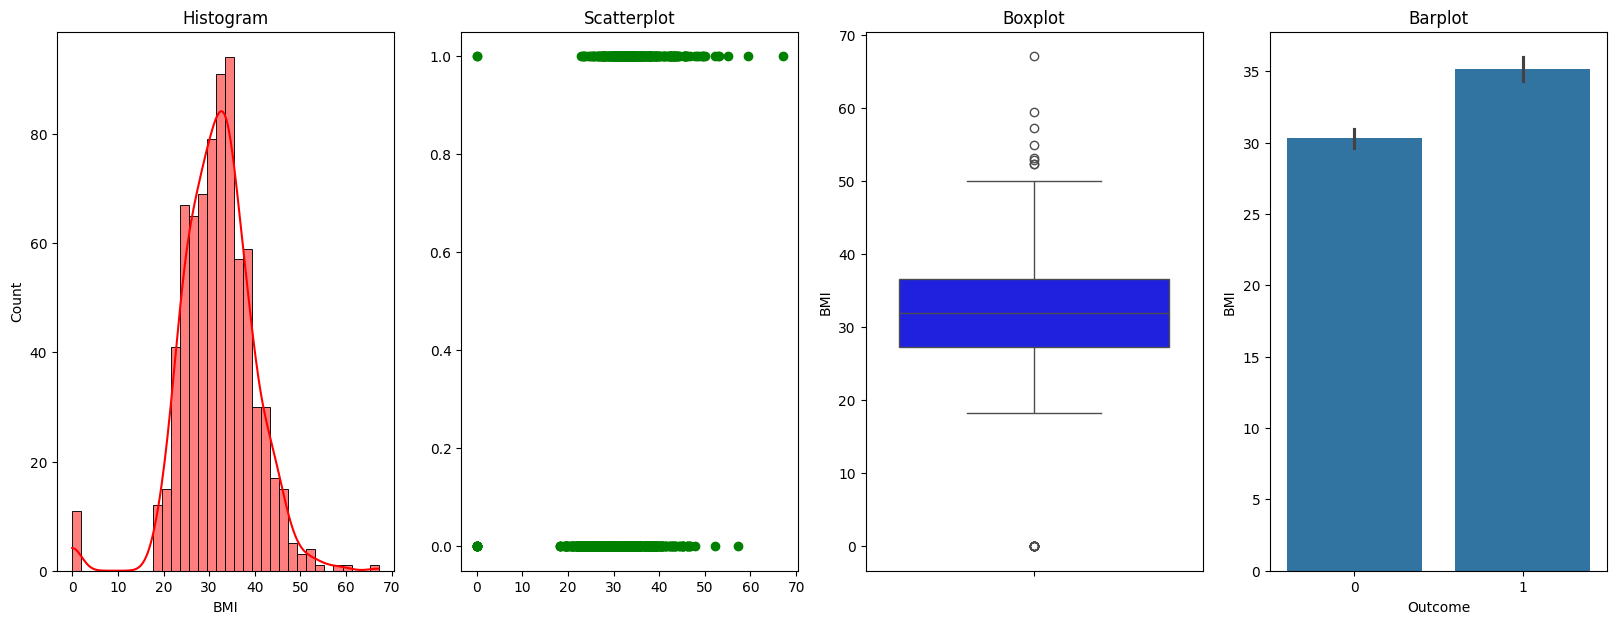

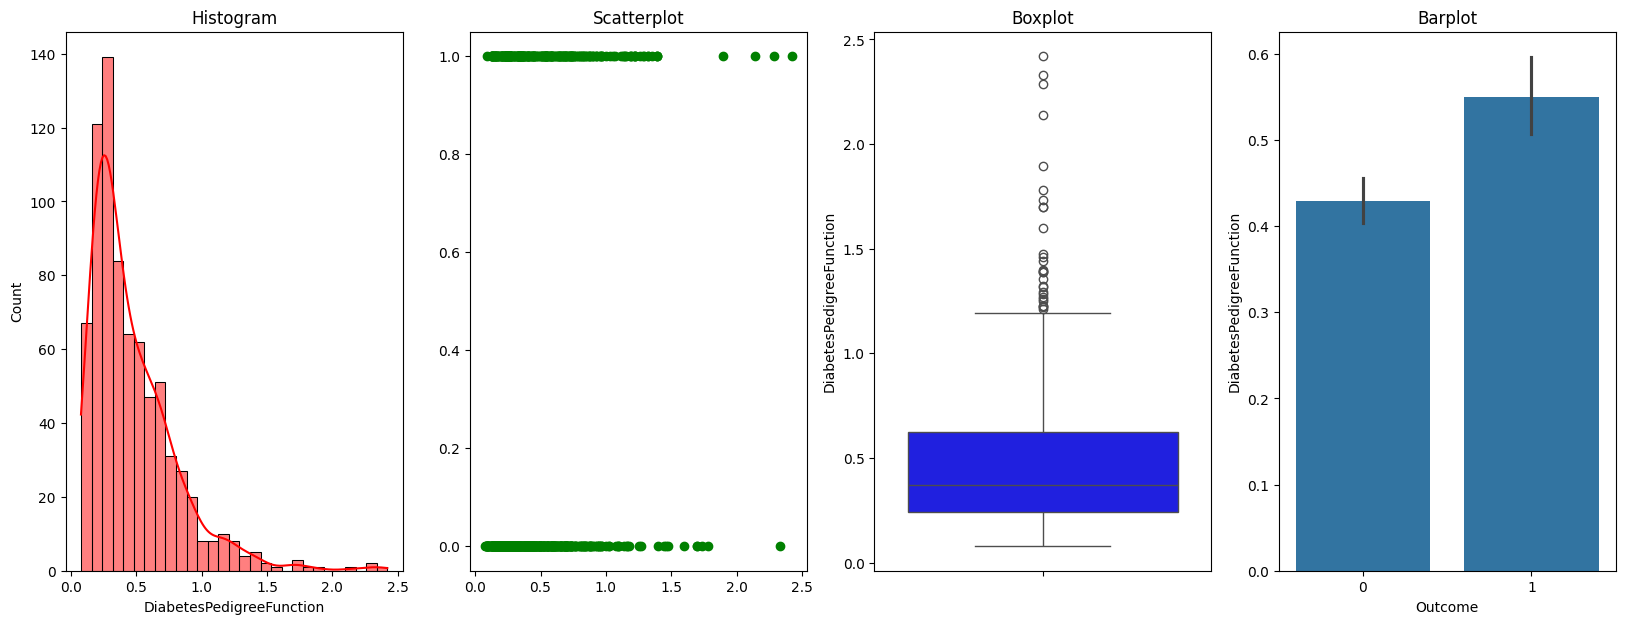

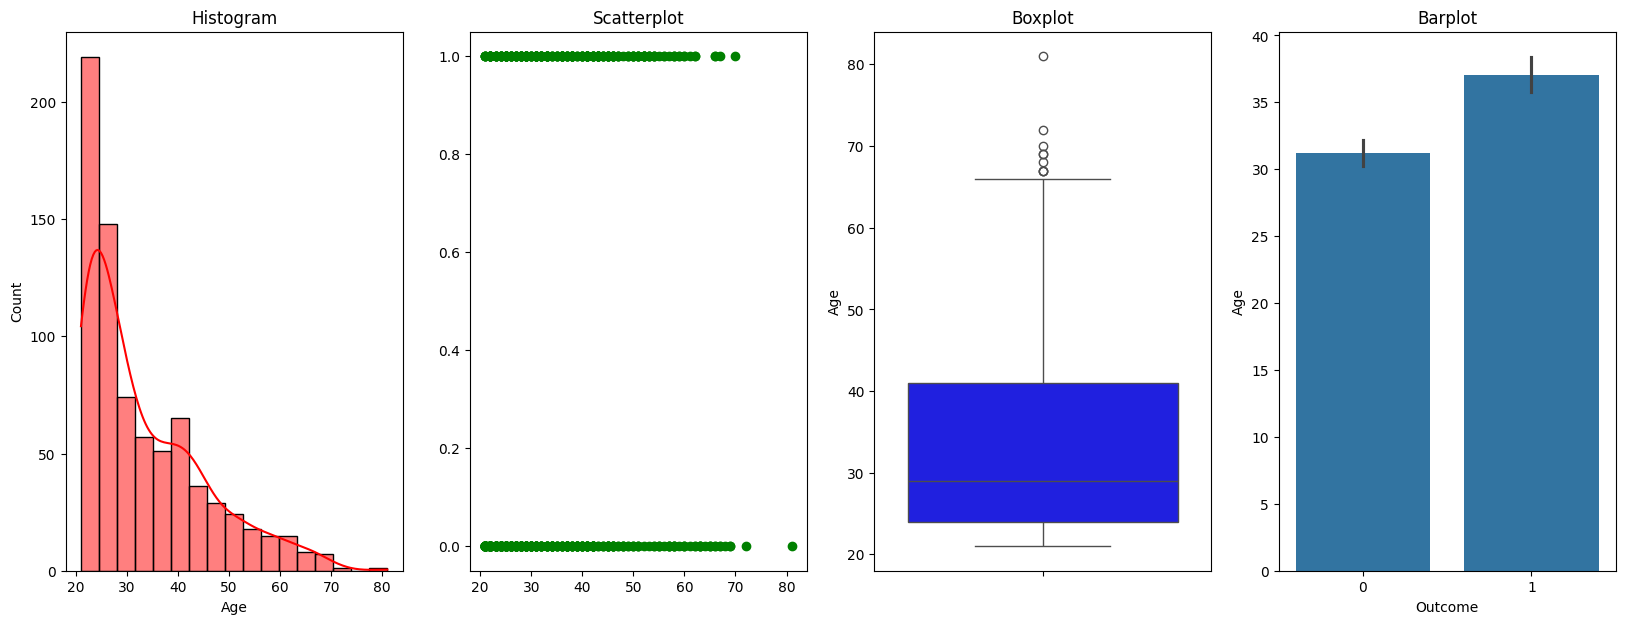

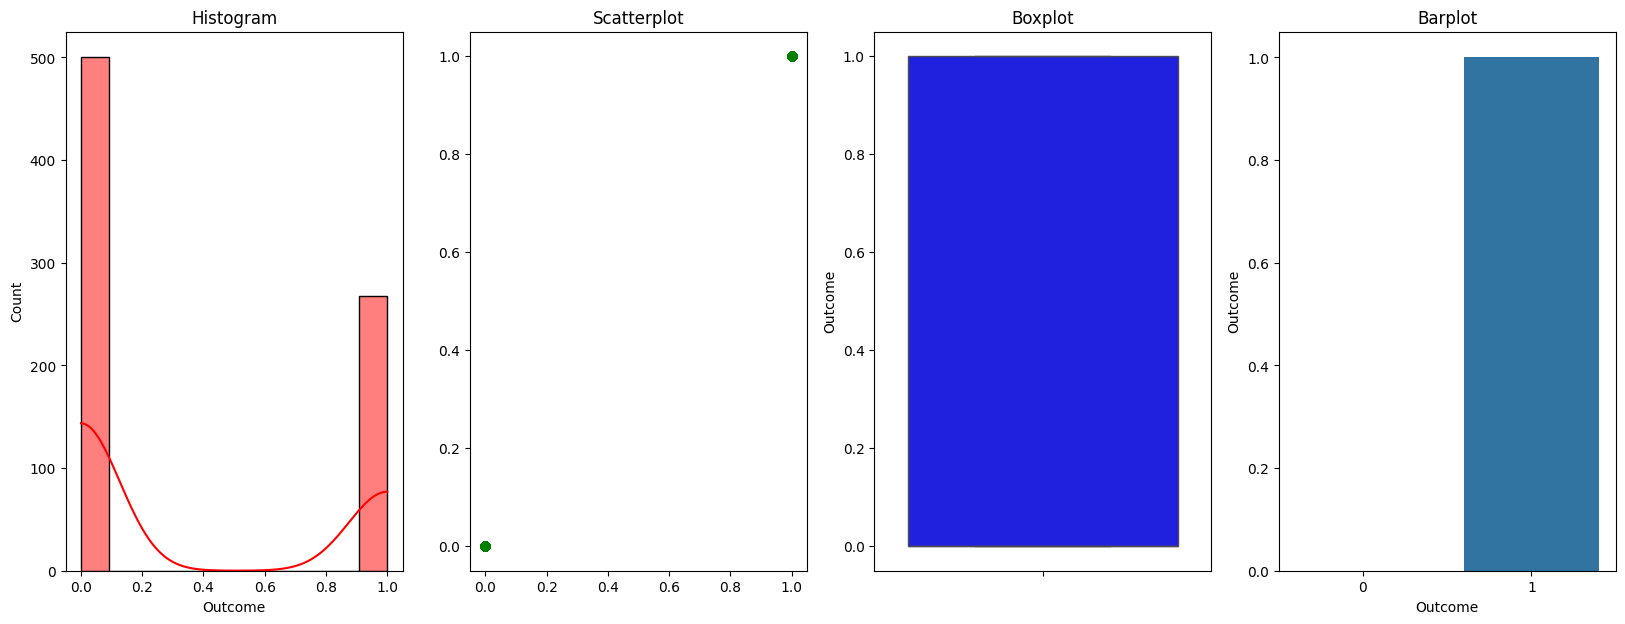

In [ ]:
for column in original_data:
  diagnostic_plots(original_data, column, "Outcome", True)

## **Modify the dataset**

In [ ]:
modified_data = original_data.copy()

In [ ]:
# Replace the median value for those columns where the actual value can't be zero or less then zero.
for column in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
    median = modified_data[column].median()
    modified_data.loc[modified_data[column] <= 0, column] = median

In [ ]:
# Turn the features' which have exponential like deviation into normal like deviation
constant: float = 1.0

modified_data["ln_pregnancies"] = numpy.log(modified_data["Pregnancies"] + constant)
modified_data["ln_insulin"] = numpy.log(modified_data["Insulin"] + constant)
modified_data["ln_age"] = numpy.log(modified_data["Age"] + constant)
modified_data["ln_diabetes_pedigree_function"] = numpy.log(modified_data["DiabetesPedigreeFunction"] + constant)

modified_data[["ln_pregnancies", "ln_insulin", "ln_age", "ln_diabetes_pedigree_function"]].fillna(modified_data[["ln_pregnancies", "ln_insulin", "ln_age", "ln_diabetes_pedigree_function"]].mean(), inplace=True)

modified_data[["ln_pregnancies", "ln_insulin", "ln_age", "ln_diabetes_pedigree_function"]].head()

,ln_pregnancies,ln_insulin,ln_age,ln_diabetes_pedigree_function
0,1.945910,3.449988,3.931826,0.486738
1,0.693147,3.449988,3.465736,0.300845
2,2.197225,3.449988,3.496508,0.514021
3,0.693147,4.553877,3.091042,0.154436
4,0.000000,5.129899,3.526361,1.190279


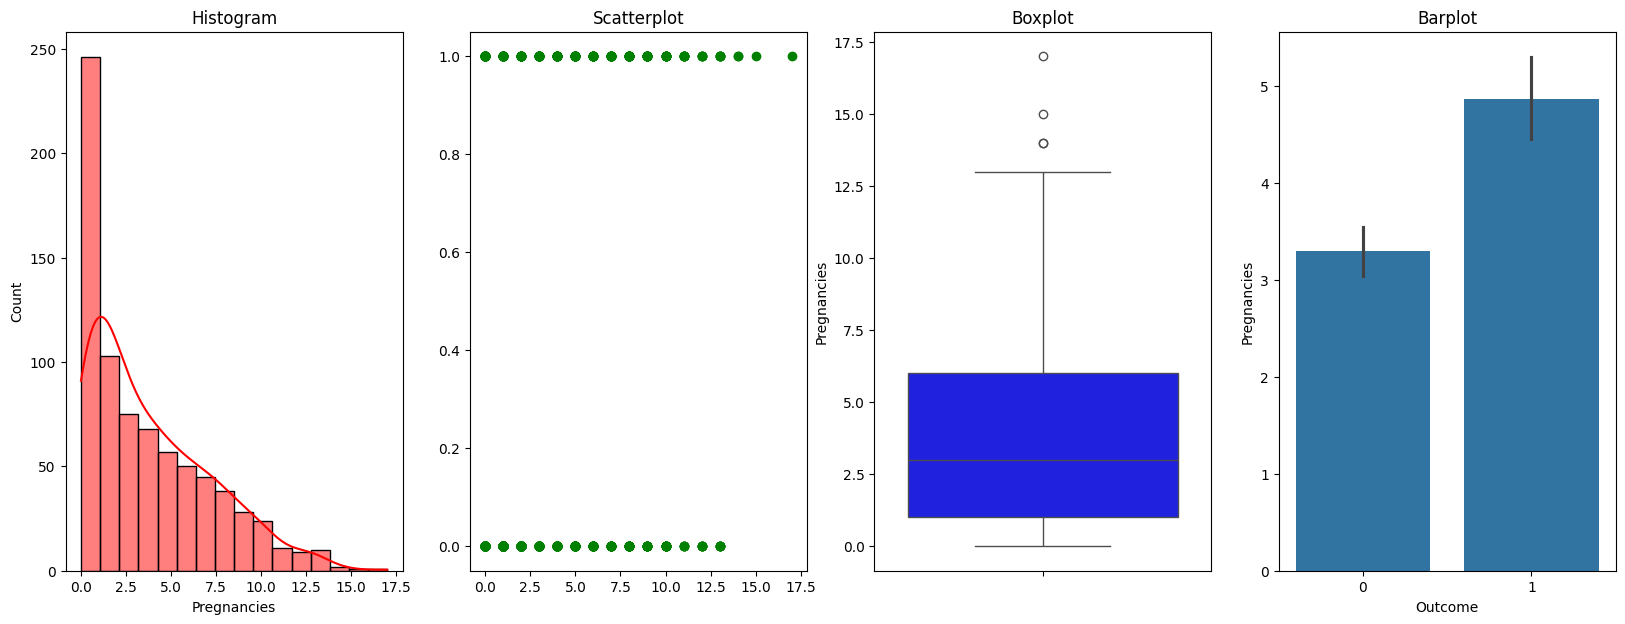

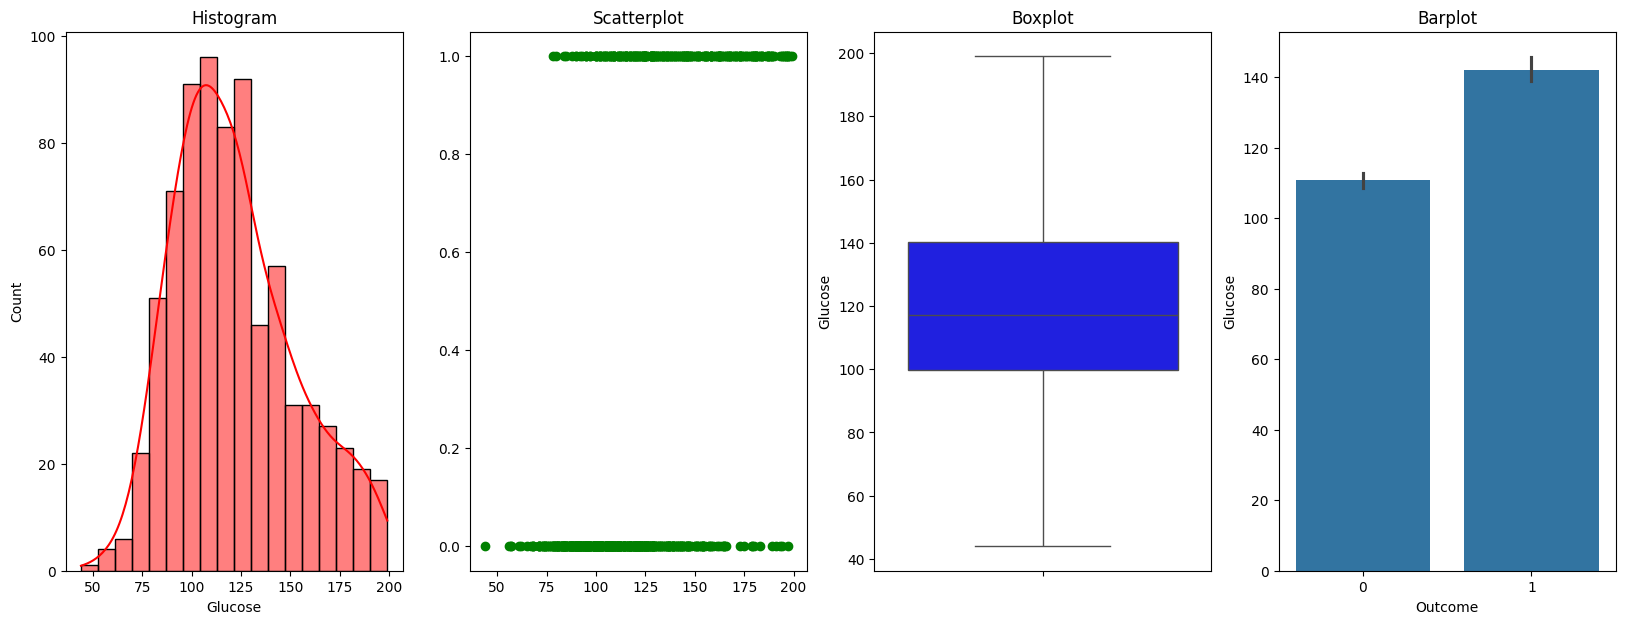

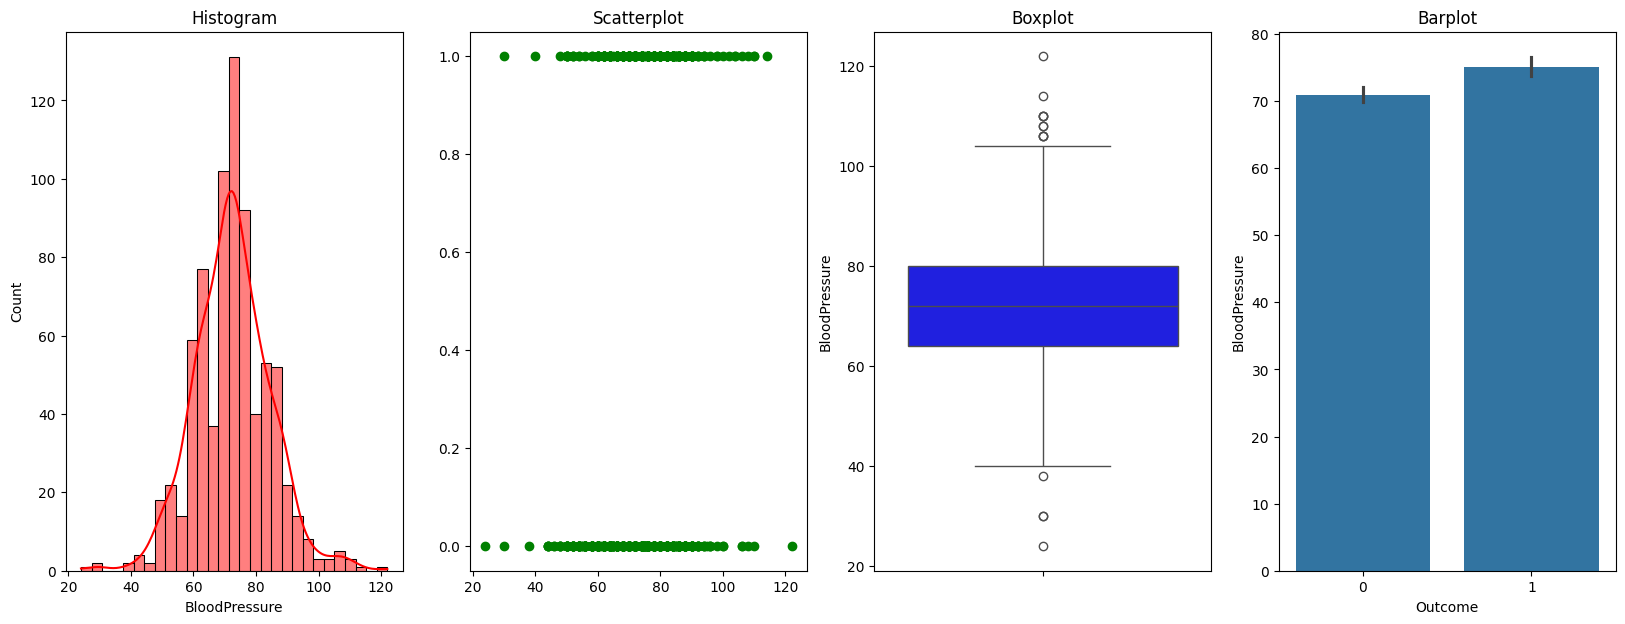

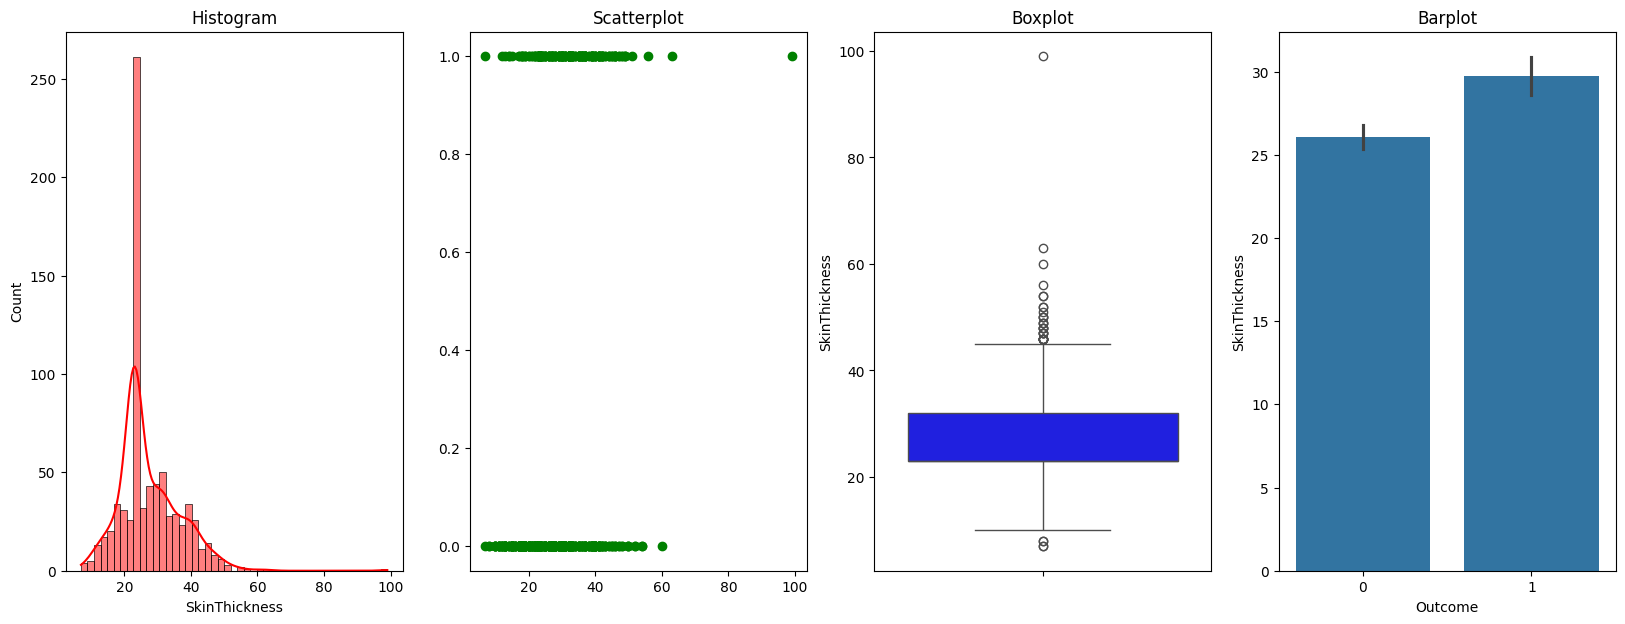

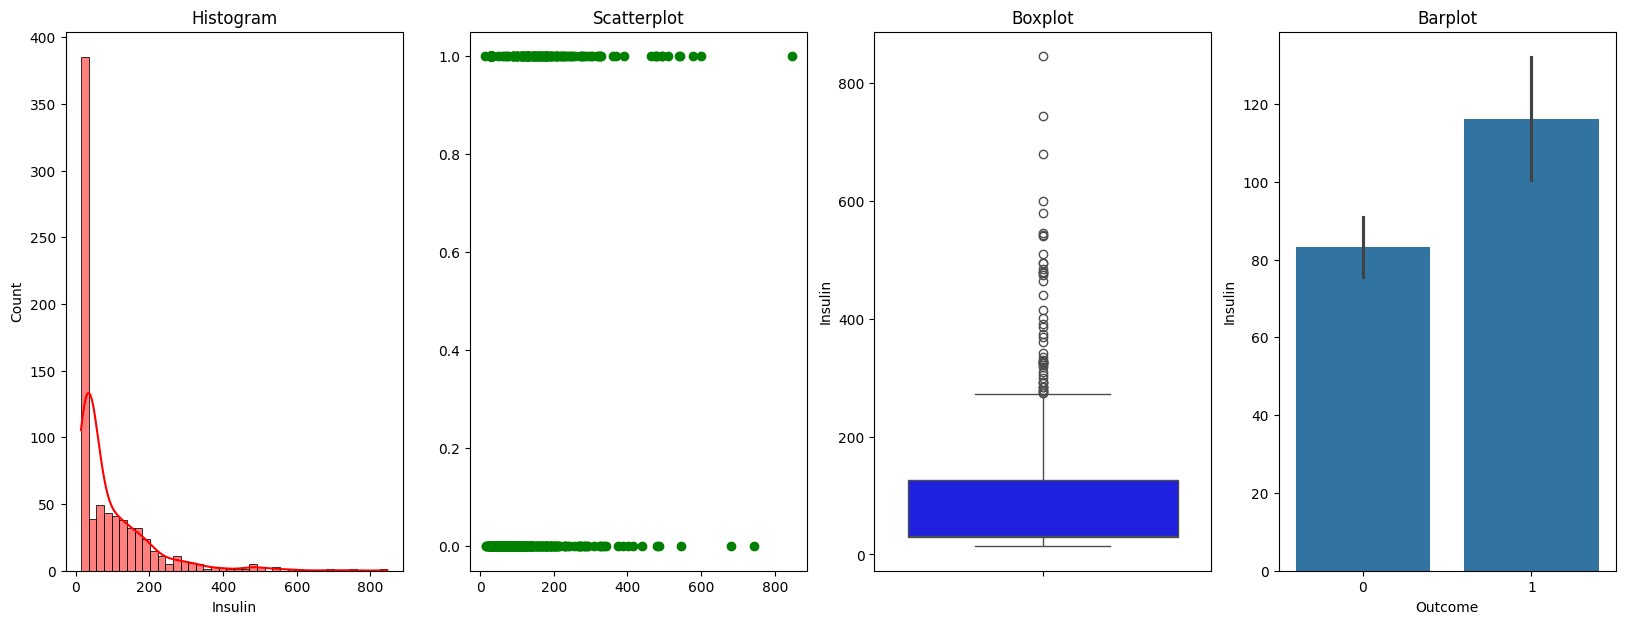

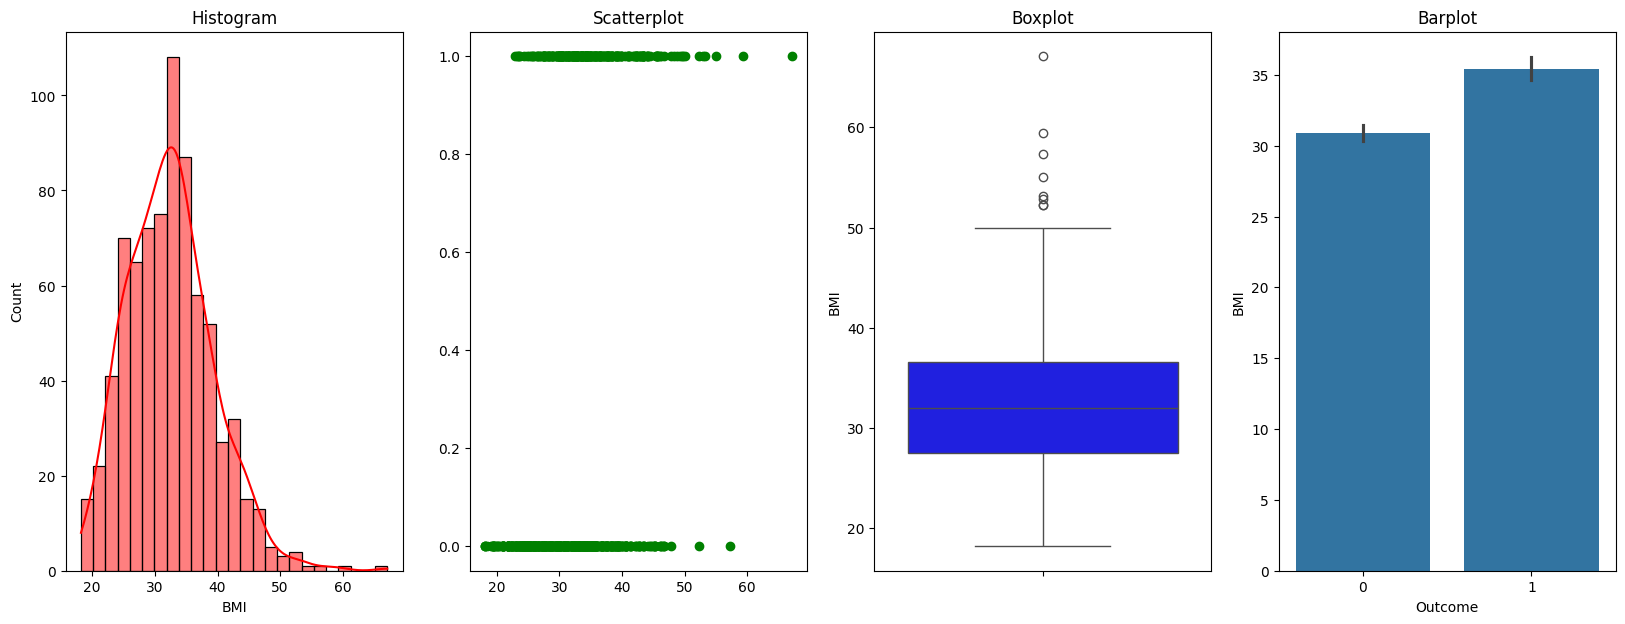

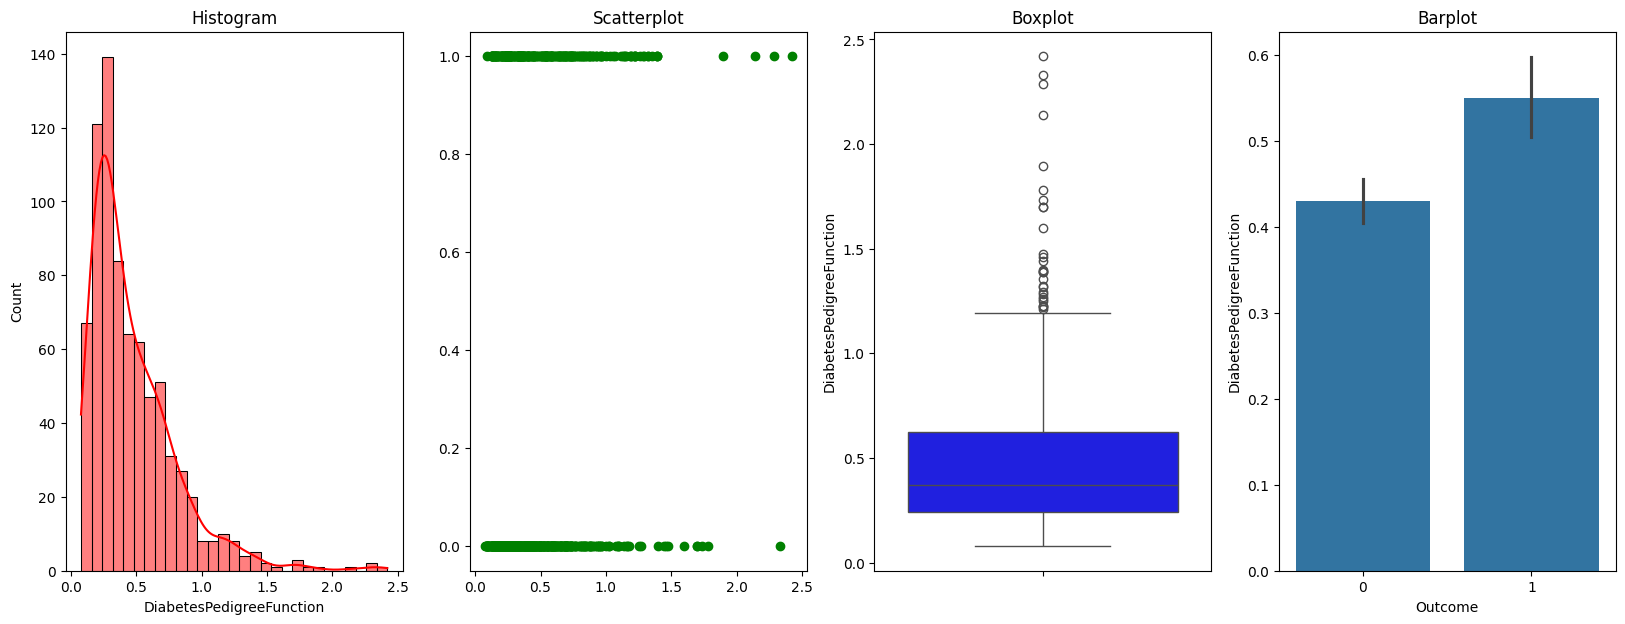

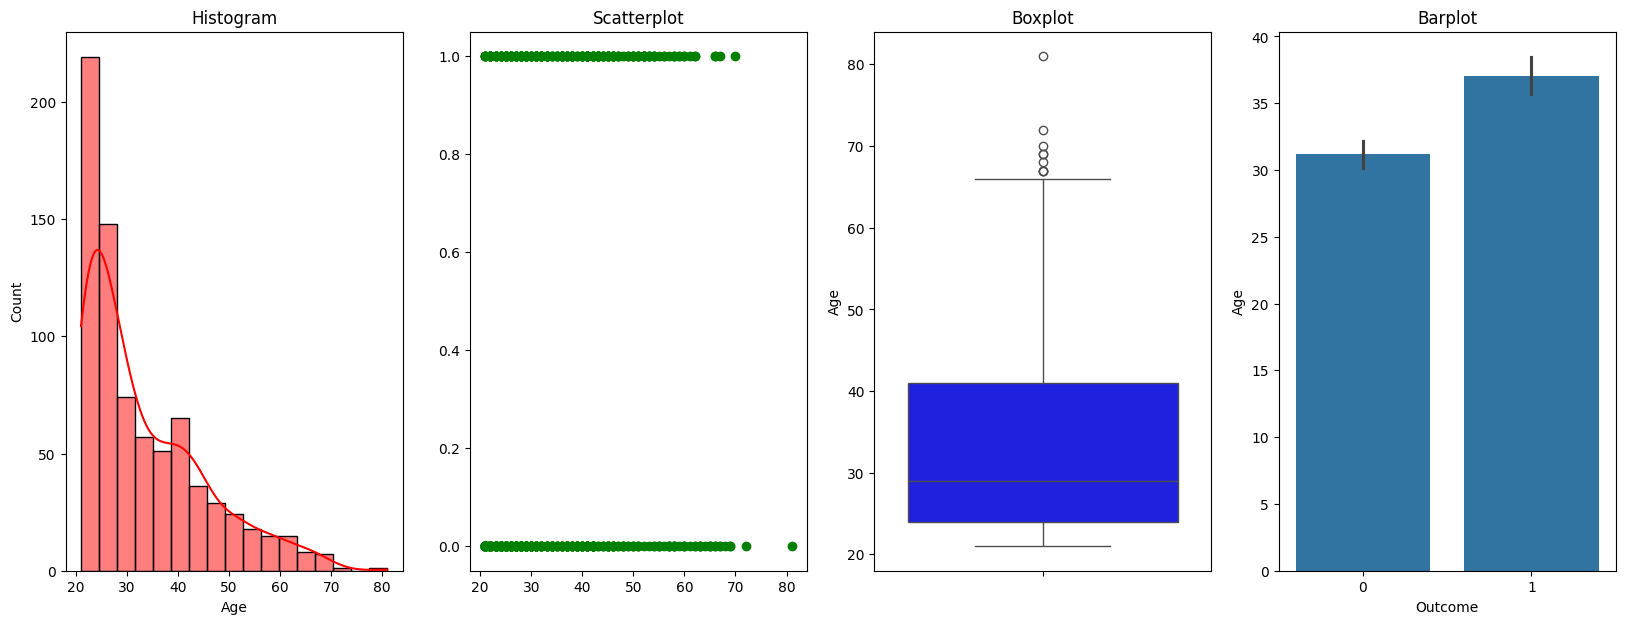

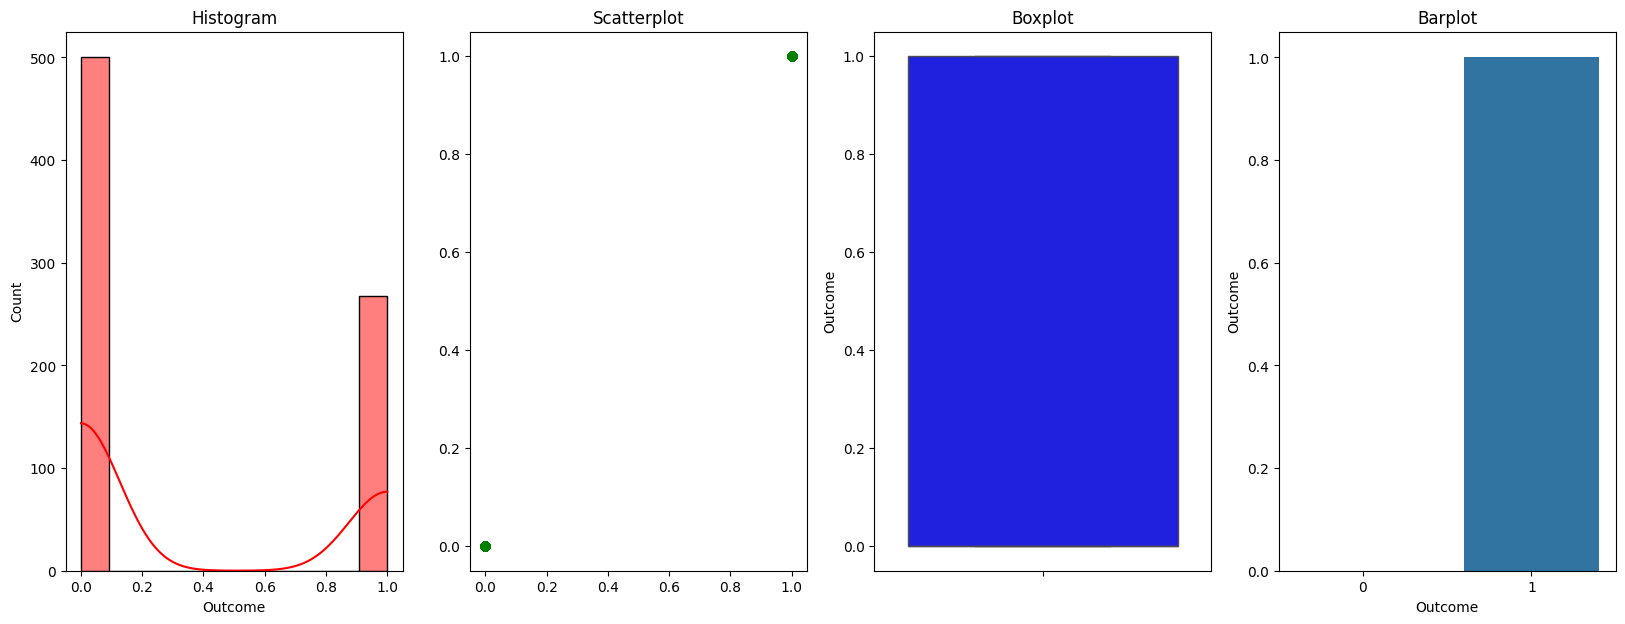

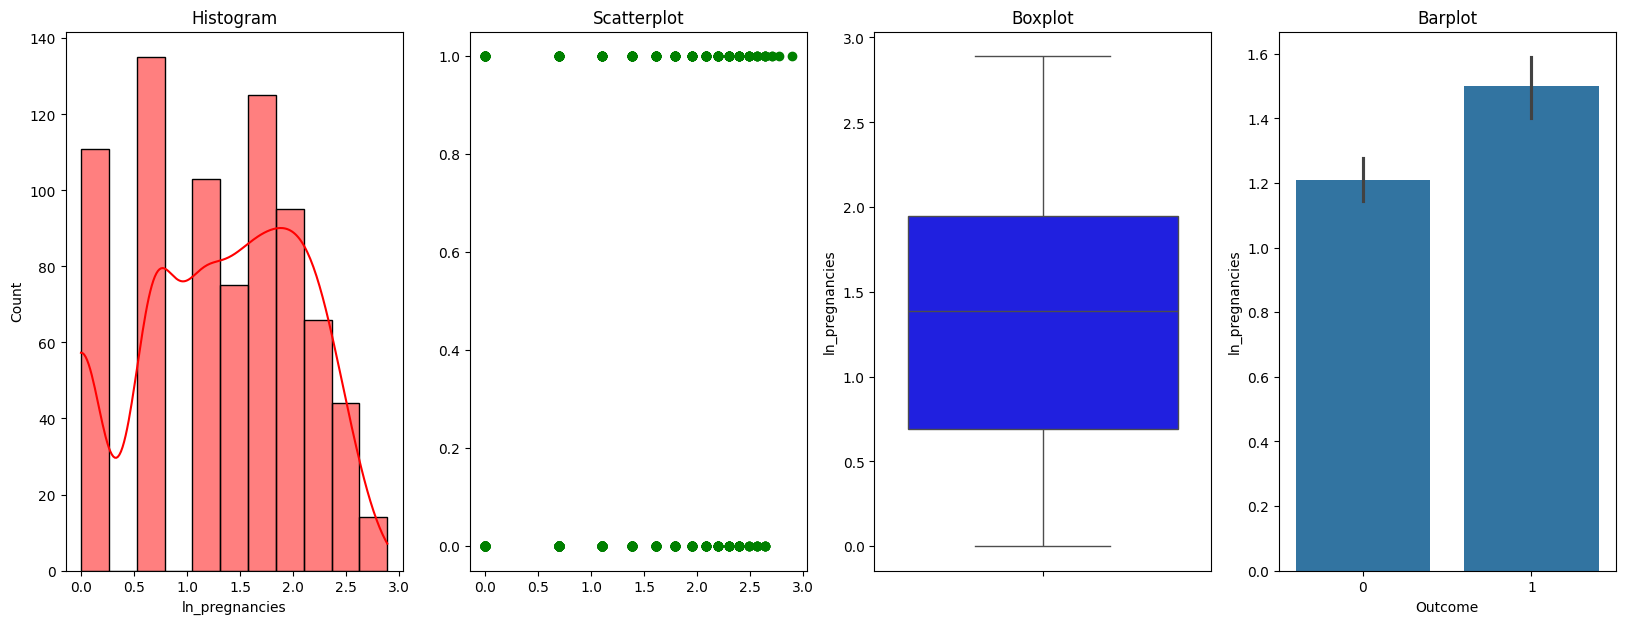

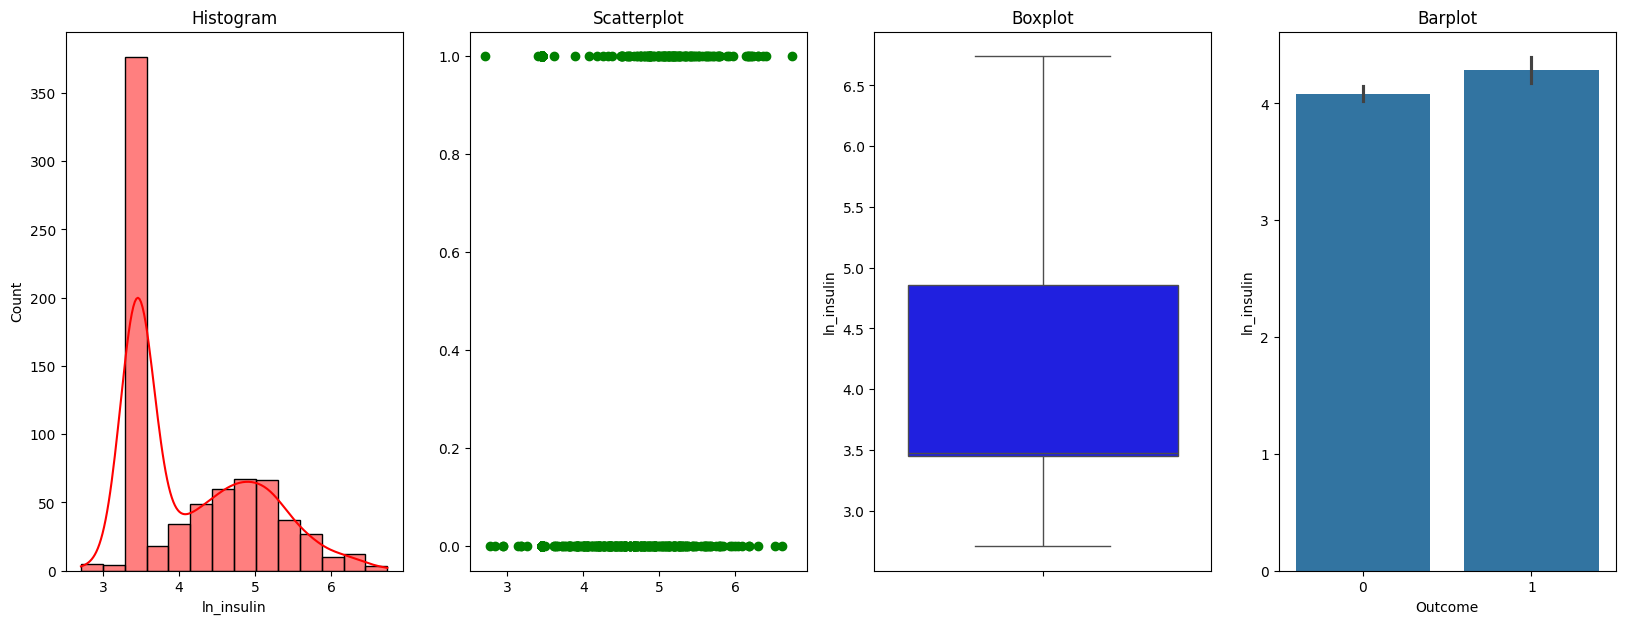

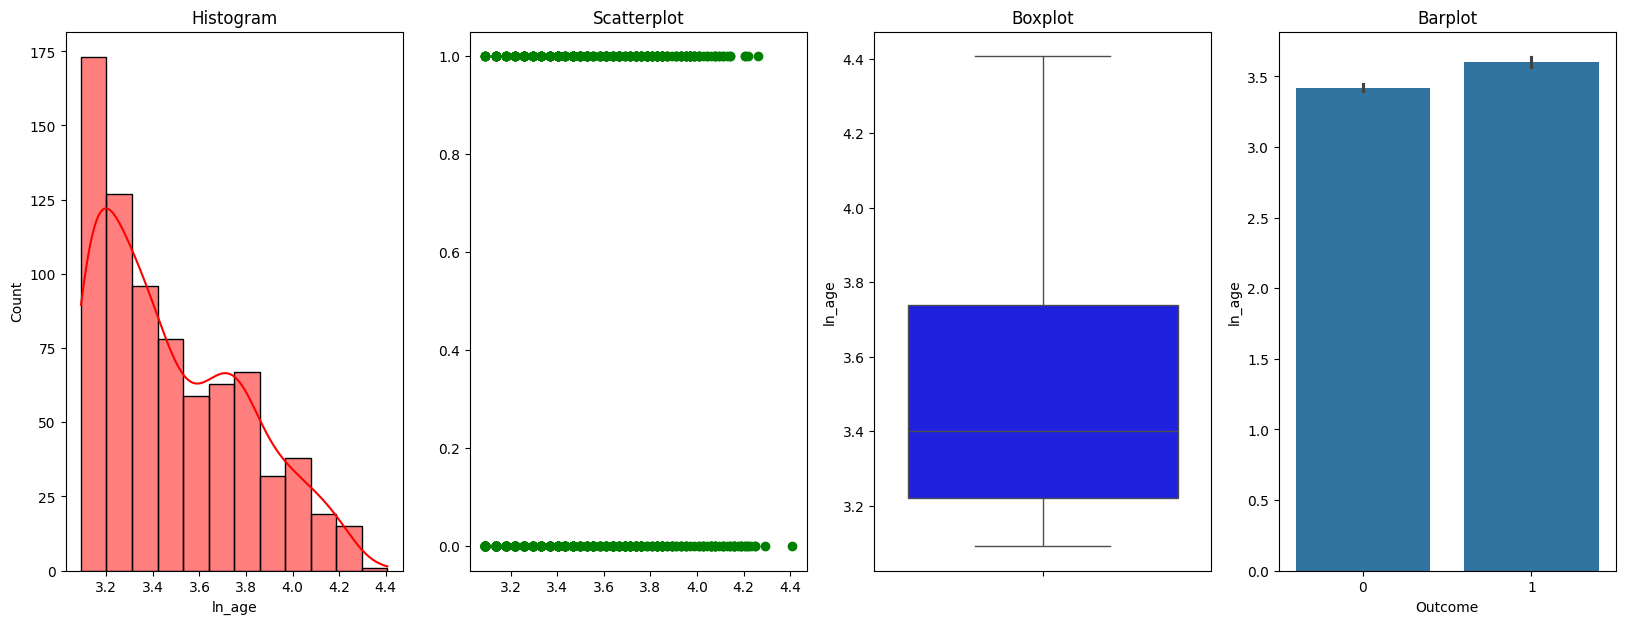

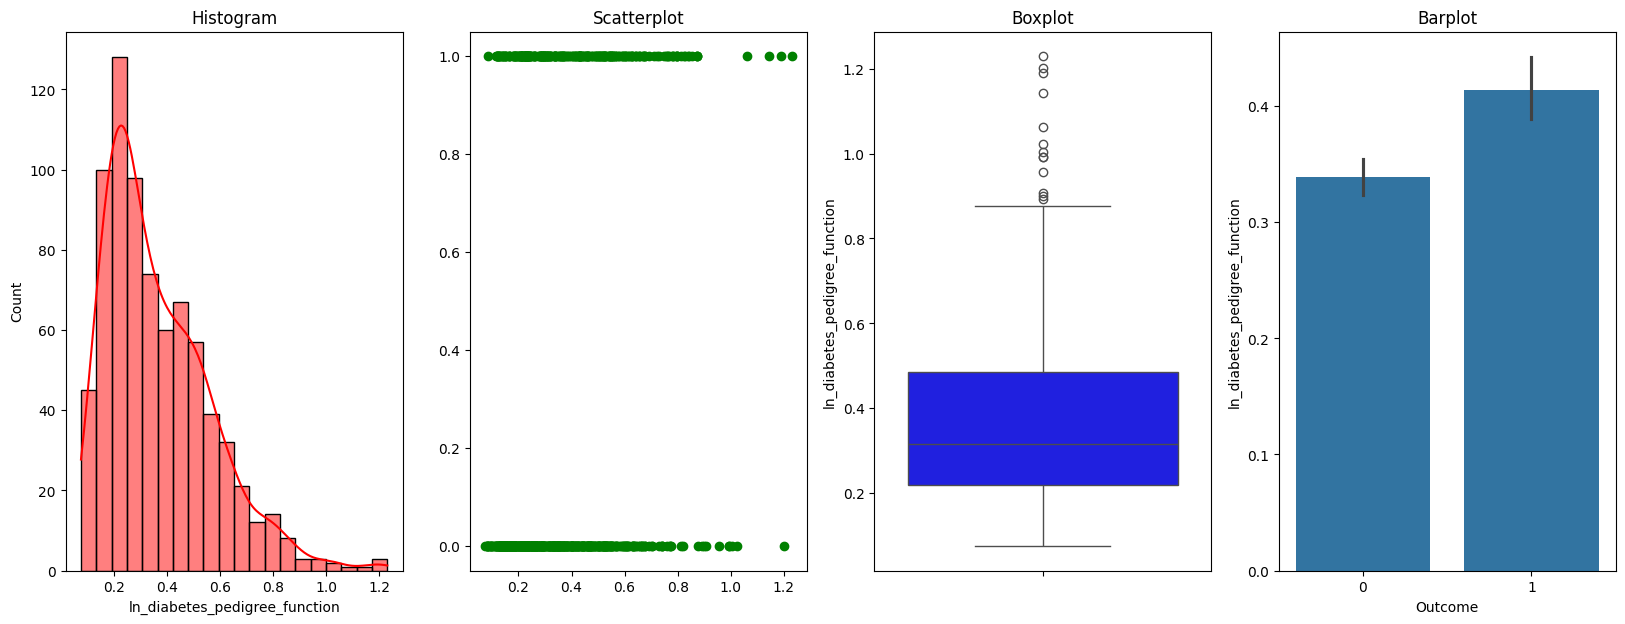

In [ ]:
for column in modified_data.columns:
  diagnostic_plots(modified_data, column, "Outcome", False)

In [ ]:
# Saving preprocessed dataset.
final_dataset = modified_data[[
    "Outcome",
    "Pregnancies",
    "ln_pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "ln_insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "ln_diabetes_pedigree_function",
    "Age",
    "ln_age"]]

feature_names = ["Pregnancies",
    "ln_pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "ln_insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "ln_diabetes_pedigree_function",
    "Age",
    "ln_age"]

final_dataset.to_csv("diabetes_modified.csv", index=False, float_format="%.6f")

In [ ]:
final_dataset.head()

,Outcome,Pregnancies,ln_pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,ln_insulin,BMI,DiabetesPedigreeFunction,ln_diabetes_pedigree_function,Age,ln_age
0,1,6,1.945910,148,72,35,30.5,3.449988,33.6,0.627,0.486738,50,3.931826
1,0,1,0.693147,85,66,29,30.5,3.449988,26.6,0.351,0.300845,31,3.465736
2,1,8,2.197225,183,64,23,30.5,3.449988,23.3,0.672,0.514021,32,3.496508
3,0,1,0.693147,89,66,23,94.0,4.553877,28.1,0.167,0.154436,21,3.091042
4,1,0,0.000000,137,40,35,168.0,5.129899,43.1,2.288,1.190279,33,3.526361


## **Evaluate other algorithms**

In [ ]:
# Dataset split
x = final_dataset.drop("Outcome", axis=1)
y = final_dataset["Outcome"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def feature_selection(direction_type, test_scoring):
  # Logistic Regression model
  log_reg = LogisticRegression(n_jobs=4, penalty="l2", C=1.0, solver="lbfgs", max_iter=1024)

  # Forward Feature Selection using SequentialFeatureSelector
  selector = SequentialFeatureSelector(log_reg, direction=direction_type, scoring=test_scoring)
  selector.fit(X_train, y_train)

  # Get selected features
  selected_features = numpy.array(feature_names)[selector.support_]

  # Print results
  print("Selected Features:", selected_features)

  # Train model with selected features
  X_train_selected = selector.transform(X_train)
  X_test_selected = selector.transform(X_test)
  log_reg.fit(X_train_selected, y_train)

  # Evaluate performance
  y_test_pred = log_reg.predict(X_test_selected)
  y_test_probs = log_reg.predict_proba(X_test_selected)[:, 1]

  test_accuracy: float = accuracy_score(y_test, y_test_pred)
  test_precision: float = precision_score(y_test, y_test_pred)
  test_recall: float = recall_score(y_test, y_test_pred)

  f1_score_result: float = f1_score(y_test, y_test_pred)

  roc_auc: float = roc_auc_score(y_test, y_test_probs)
  pr_auc: float = average_precision_score(y_test, y_test_probs)

  gini_score: float = 2 * roc_auc - 1

  print(f"Model Accuracy with Selected Features: {test_accuracy:.4f}")
  print(f"Model Precision with Selected Features: {test_precision:.4f}")
  print(f"Model Recall with Selected Features: {test_recall:.4f}")
  print(f"Model F1-score with Selected Features: {f1_score_result:.4f}")
  print(f"Model ROC-AUC with Selected Features: {roc_auc:.4f}")
  print(f"Model PR-AUC with Selected Features: {pr_auc:.4f}")
  print(f"Model Gini with Selected Features: {gini_score:.4f}")

### **Backward feature selection ACCURACY**

In [ ]:
feature_selection("backward", "roc_auc")

Selected Features: ['Glucose' 'ln_insulin' 'BMI' 'ln_diabetes_pedigree_function' 'Age'
 'ln_age']
Model Accuracy with Selected Features: 0.7662
Model Precision with Selected Features: 0.7368
Model Recall with Selected Features: 0.5185
Model F1-score with Selected Features: 0.6087
Model ROC-AUC with Selected Features: 0.8348
Model PR-AUC with Selected Features: 0.7517
Model Gini with Selected Features: 0.6696


### **Forward feature selection ACCURACY**

In [ ]:
feature_selection("forward", "roc_auc")

Selected Features: ['Glucose' 'ln_insulin' 'BMI' 'ln_diabetes_pedigree_function' 'Age'
 'ln_age']
Model Accuracy with Selected Features: 0.7662
Model Precision with Selected Features: 0.7368
Model Recall with Selected Features: 0.5185
Model F1-score with Selected Features: 0.6087
Model ROC-AUC with Selected Features: 0.8348
Model PR-AUC with Selected Features: 0.7517
Model Gini with Selected Features: 0.6696


### **Backward feature selection ROC-AUC**

In [ ]:
custom_scorer = make_scorer(average_precision_score, needs_proba=True, greater_is_better=True)

feature_selection("backward", custom_scorer)

Selected Features: ['ln_insulin' 'BMI' 'DiabetesPedigreeFunction'
 'ln_diabetes_pedigree_function' 'Age' 'ln_age']
Model Accuracy with Selected Features: 0.6883
Model Precision with Selected Features: 0.5789
Model Recall with Selected Features: 0.4074
Model F1-score with Selected Features: 0.4783
Model ROC-AUC with Selected Features: 0.7867
Model PR-AUC with Selected Features: 0.6515
Model Gini with Selected Features: 0.5733


### **Forward feature selection ROC-AUC**

In [ ]:
custom_scorer = make_scorer(average_precision_score, needs_proba=True, greater_is_better=True)

feature_selection("forward", custom_scorer)

Selected Features: ['Pregnancies' 'ln_pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness'
 'Insulin']
Model Accuracy with Selected Features: 0.7403
Model Precision with Selected Features: 0.6667
Model Recall with Selected Features: 0.5185
Model F1-score with Selected Features: 0.5833
Model ROC-AUC with Selected Features: 0.8200
Model PR-AUC with Selected Features: 0.7238
Model Gini with Selected Features: 0.6400


### **Backward feature selection ACC+PREC**

In [ ]:
def weighted_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * prec

# Convert into an sklearn scorer
custom_scorer = make_scorer(weighted_score, greater_is_better=True)

feature_selection("backward", custom_scorer)

Selected Features: ['Pregnancies' 'Glucose' 'BMI' 'DiabetesPedigreeFunction' 'Age' 'ln_age']
Model Accuracy with Selected Features: 0.7208
Model Precision with Selected Features: 0.6222
Model Recall with Selected Features: 0.5185
Model F1-score with Selected Features: 0.5657
Model ROC-AUC with Selected Features: 0.8224
Model PR-AUC with Selected Features: 0.6942
Model Gini with Selected Features: 0.6448


### **Forward feature selection ACC+PREC**

In [ ]:
def weighted_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * prec

# Convert into an sklearn scorer
custom_scorer = make_scorer(weighted_score, greater_is_better=True)

feature_selection("forward", custom_scorer)

Selected Features: ['Pregnancies' 'ln_pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness'
 'BMI']
Model Accuracy with Selected Features: 0.7013
Model Precision with Selected Features: 0.5800
Model Recall with Selected Features: 0.5370
Model F1-score with Selected Features: 0.5577
Model ROC-AUC with Selected Features: 0.8007
Model PR-AUC with Selected Features: 0.6458
Model Gini with Selected Features: 0.6015


## **Feature selection with DEAP ACCURACY**

In [ ]:
# DEAP TRY
!pip install deap
from deap import base, creator, tools, algorithms
import random

x = final_dataset.drop("Outcome", axis=1)
y = final_dataset["Outcome"].astype(int)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

# Define Fitness function (maximize accuracy)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create individual: Binary list where 1 = select feature, 0 = ignore
def create_individual():
    return [random.randint(0, 1) for _ in range(X_train.shape[1])]

# Evaluate function: Train model with selected features
def evaluate(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if len(selected_features) == 0:
        return (0,)  # Avoid empty feature sets

    X_train_selected = X_train[:, selected_features]
    X_validation_selected = X_validation[:, selected_features]
    model = LogisticRegression(n_jobs=4, penalty="l2", C=1.0, solver="lbfgs", max_iter=1024)

    model.fit(X_train_selected, y_train)

    # Evaluate performance
    y_probs = model.predict_proba(X_validation_selected)[:, 1]
    #score:float = roc_auc_score(y_test, y_probs)
    score:float = average_precision_score(y_test, y_probs)

    return (score,)

# GA settings
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=50)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run Genetic Algorithm
population = toolbox.population(n=200)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=True)

# Best solution
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]

print("Selected Features:", numpy.array(feature_names)[selected_features])

# Train model with selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]
log_reg = LogisticRegression(n_jobs=4, penalty="l2", C=1.0, solver="lbfgs", max_iter=1024)
log_reg.fit(X_train_selected, y_train)

# Evaluate performance
y_test_pred = log_reg.predict(X_test_selected)
y_test_probs = log_reg.predict_proba(X_test_selected)[:, 1]

test_accuracy: float = accuracy_score(y_test, y_test_pred)
test_precision: float = precision_score(y_test, y_test_pred)
test_recall: float = recall_score(y_test, y_test_pred)

f1_score_result: float = f1_score(y_test, y_test_pred)

roc_auc: float = roc_auc_score(y_test, y_test_probs)
pr_auc: float = average_precision_score(y_test, y_test_probs)

gini_score: float = 2 * roc_auc - 1

print(f"Model Accuracy with Selected Features: {test_accuracy:.4f}")
print(f"Model Precision with Selected Features: {test_precision:.4f}")
print(f"Model Recall with Selected Features: {test_recall:.4f}")
print(f"Model F1-score with Selected Features: {f1_score_result:.4f}")
print(f"Model ROC-AUC with Selected Features: {roc_auc:.4f}")
print(f"Model PR-AUC with Selected Features: {pr_auc:.4f}")
print(f"Model Gini with Selected Features: {gini_score:.4f}")

gen	nevals
0  	200   
1  	120   
2  	113   
3  	127   
4  	113   
5  	144   
6  	134   
7  	131   
8  	118   
9  	115   
10 	116   
11 	136   
12 	110   
13 	118   
14 	133   
15 	123   
16 	128   
17 	114   
18 	127   
19 	115   
20 	116   
21 	113   
22 	133   
23 	108   
24 	125   
25 	112   
26 	134   
27 	119   
28 	130   
29 	139   
30 	133   
31 	118   
32 	132   
33 	117   
34 	129   
35 	124   
36 	112   
37 	133   
38 	117   
39 	126   
40 	130   
Selected Features: ['Pregnancies' 'Insulin' 'ln_insulin' 'DiabetesPedigreeFunction'
 'ln_diabetes_pedigree_function']
Model Accuracy with Selected Features: 0.7532
Model Precision with Selected Features: 0.7500
Model Recall with Selected Features: 0.4444
Model F1-score with Selected Features: 0.5581
Model ROC-AUC with Selected Features: 0.7304
Model PR-AUC with Selected Features: 0.6813
Model Gini with Selected Features: 0.4607
